In [825]:
import sys
sys.path.append("..")

import Essentials

In [826]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [827]:
data_archive = np.load('../Data_Average_Nikita.npz', allow_pickle=True)

In [828]:
def prepare_Y(y):
    timestamp = y[:, 1]   
    y = y[:, 0].reshape(len(y), 1)
    y = y.astype(np.float64)

    return y, timestamp

In [829]:
all_X_1 = data_archive['all_X_1']
all_Y_1 = data_archive['all_Y_1']

all_X_2 = data_archive['all_X_2']
all_Y_2 = data_archive['all_Y_2']

all_X_3 = data_archive['all_X_3']
all_Y_3 = data_archive['all_Y_3']

x_summer_half_2 = data_archive['x_summer_half_2']
y_summer_half_2 = data_archive['y_summer_half_2']
x_winter_half_2 = data_archive['x_winter_half_2']
y_winter_half_2 = data_archive['y_winter_half_2']

x_summer_half_3 = data_archive['x_summer_half_3']
y_summer_half_3 = data_archive['y_summer_half_3']
x_winter_half_3 = data_archive['x_winter_half_3']
y_winter_half_3 = data_archive['y_winter_half_3']

In [830]:
x_train, x_test, y_train, y_test = train_test_split(all_X_1, all_Y_1, test_size=0.3, random_state=42)

In [831]:
all_X_1.shape

(107, 87)

In [832]:
y_train, timestamp_train = prepare_Y(y_train)

In [833]:
y_test, timestamp_test = prepare_Y(y_test)

In [834]:
x_train.shape

(74, 87)

In [835]:
x_test.shape

(33, 87)

In [836]:
x_train_winter, x_test_winter, y_train_winter, y_test_winter = train_test_split(x_winter_half_2, y_winter_half_2, test_size=0.2, random_state=42)

In [837]:
x_train_summer, x_test_summer, y_train_summer, y_test_summer = train_test_split(x_summer_half_2, y_summer_half_2, test_size=0.2, random_state=42)

In [838]:
y_train_summer, timestamp_train_summer = prepare_Y(y_train_summer)

In [839]:
y_train_winter, timestamp_train_winter = prepare_Y(y_train_winter)

In [840]:
y_test_summer, timestamp_test_summer = prepare_Y(y_test_summer)

In [841]:
y_test_winter, timestamp_test_winter = prepare_Y(y_test_winter)

In [842]:
class PCA_LR(Essentials.SoftSensor):
    def __init__(self, name, x_train, y_train,x_test,y_test):
        super().__init__(name)
        self.x_scaler = StandardScaler()
        self.x_pca = None  # Инициализация будет в методе tune_pca_components
        self.fit_scaler(x_train)

        # Определение максимального количества компонент на основе минимальной размерности x_train
        self.max_components = min(x_train.shape[1], x_train.shape[0])

        # Поиск оптимального количества компонент
        self.tune_pca_components(x_train, y_train, x_test, y_test)

        # Обучение модели
        self.model = LinearRegression()
        self.train(x_train, y_train)
        self.set_model(self.model)

    def tune_pca_components(self, x_train, y_train, x_test, y_test):
        r2_scores = []
        for n_components in range(1, self.max_components + 1):
            pca = PCA(n_components=n_components)
            self.fit_pca(pca, x_train)
            pca_x_train = self.preprocessing(x_train)

            # Обучение модели на обучающей выборке с текущим количеством компонент
            model = LinearRegression()
            model.fit(pca_x_train, y_train)

            # Преобразование тестовой выборки и предсказание
            pca_x_test = self.preprocessing(x_test)
            y_pred = model.predict(pca_x_test)

            # Расчёт R^2 и обновление списка r2_scores
            r2 = r2_score(y_test, y_pred)
            r2_scores.append(r2)

        # Определение числа компонент с максимальным R^2
        optimal_n_components = np.argmax(r2_scores) + 1
        print(f"Оптимальное количество главных компонент: {optimal_n_components}")

        # Обучение PCA с оптимальным числом компонент
        self.x_pca = PCA(n_components=optimal_n_components)
        self.x_pca.fit(self.x_scaler.transform(x_train))
    
    def preprocessing(self, x):
        try:
            x_scaled = self.x_scaler.transform(x)
            return self.x_pca.transform(x_scaled)
        except BaseException as err:
            print("Ошибка скейлера")
            raise err    
    
    def postprocessing(self, x):
        return x

    def fit_scaler(self, x):
        self.x_scaler.fit(x)

    def fit_pca(self, pca, x):
        scaled_x = self.x_scaler.transform(x)
        pca.fit(scaled_x)
        self.x_pca = pca
    
    def evaluate_model(self, x):
        predictions = self.get_model().predict(x)
        return predictions

    def train(self, x_train, y_train):
        pca_x = self.preprocessing(x_train)
        self.model.fit(pca_x,y_train)

    def __str__(self):
        coef_lines = [f"Коэффициент {i + 1}: {coef:.6f}" for i, coef in enumerate(self.model.coef_.flatten())]
        coef_str = '\n'.join(coef_lines)
        intercept = self.model.intercept_
        if isinstance(intercept, np.ndarray):
            intercept = intercept.item(0)
        return f"{coef_str}\nСвободный член (intercept): {intercept:.6f}"

In [843]:
PCA_LR_test = PCA_LR("PCA_LR" ,x_train ,y_train, x_test, y_test)

Оптимальное количество главных компонент: 23


In [844]:
metric = Essentials.R2Metric()

In [845]:
print(PCA_LR_test)

Коэффициент 1: 0.398776
Коэффициент 2: -0.147810
Коэффициент 3: -0.649528
Коэффициент 4: 0.253291
Коэффициент 5: 0.294248
Коэффициент 6: 0.039336
Коэффициент 7: 0.068663
Коэффициент 8: -0.147469
Коэффициент 9: 0.396580
Коэффициент 10: -0.168786
Коэффициент 11: -0.454395
Коэффициент 12: -0.463059
Коэффициент 13: -0.149670
Коэффициент 14: -0.177457
Коэффициент 15: -0.202761
Коэффициент 16: 0.482658
Коэффициент 17: -0.263969
Коэффициент 18: 0.703773
Коэффициент 19: 0.800332
Коэффициент 20: 1.108247
Коэффициент 21: -0.836623
Коэффициент 22: 1.185416
Коэффициент 23: -0.188138
Свободный член (intercept): 57.735135


In [846]:
PCA_LR_test.test(x_test, y_test, metric)

(array([[51.38852563],
        [58.15161299],
        [56.07971216],
        [60.98500859],
        [55.00416171],
        [58.57361557],
        [60.90007915],
        [58.81768182],
        [61.43767377],
        [59.86752874],
        [52.98841562],
        [58.66676585],
        [55.84167633],
        [50.88729855],
        [58.83358219],
        [60.34748152],
        [55.74436448],
        [52.29021063],
        [57.99259115],
        [61.45338491],
        [59.09572193],
        [60.20256158],
        [57.41677968],
        [57.29235238],
        [57.45293452],
        [62.89612666],
        [54.58111815],
        [60.4842958 ],
        [59.73638927],
        [58.92686954],
        [61.17462779],
        [60.00095753],
        [58.53201824]]),
 0.7120852339681646)

In [847]:
PCA_LR_test_visual_train = Essentials.Visualizer(x_train, y_train, timestamp_train, [metric], 'Linear with PCA SoftSensor R2 metric on Train')

        Coefficient of determination
PCA_LR                      0.831648


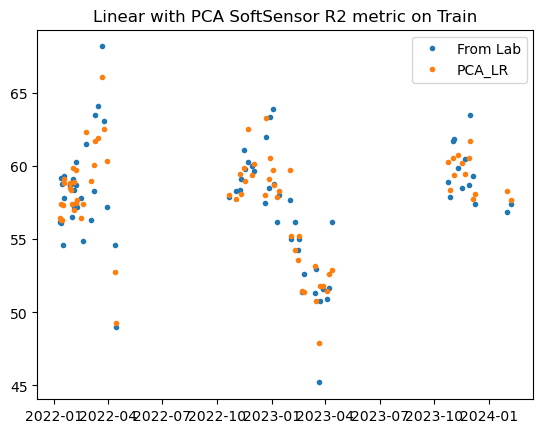

In [848]:
PCA_LR_test_visual_train.visualize([PCA_LR_test])

In [849]:
PCA_LR_test_visual_test = Essentials.Visualizer(x_test, y_test, timestamp_test, [metric], 'Linear with PCA SoftSensor R2 metric on Test')

        Coefficient of determination
PCA_LR                      0.712085


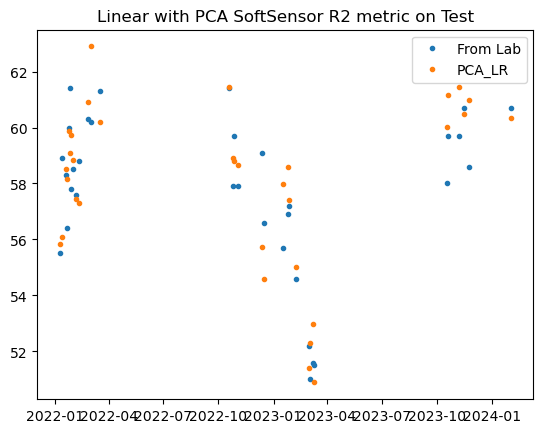

In [850]:
PCA_LR_test_visual_test.visualize([PCA_LR_test])